# Setup

In [32]:
from google.cloud import bigquery
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '../../gcp_credentials.json'
client = bigquery.Client()

# Query

In [29]:
query = """
    SELECT 
        project_name,
        forks
    FROM `opensource-observer.oso_playground.code_metrics_by_project`
    WHERE forks > 0
"""
results = client.query(query)

# Transform

### Preview our data

In [39]:
df = results.to_dataframe()
df.set_index('project_name', inplace=True)
df.head()

,forks
project_name,
Yield Protocol,236
OP Games,204
Multichain (Anyswap),864
DeFi Marketplace,51
zkBob,59


### Normalize columns into impact vectors

In [42]:
# take the log of a project's forks
df['log_forks'] = np.log(df['forks'])

# get the zscore for each project
logmean = df['log_forks'].mean()
logstd  = df['log_forks'].std()
df['zscore_forks'] = (df['log_forks'] - logmean) / logstd

# normalize to a 0-1 scale
minmax_scaler = MinMaxScaler(feature_range=(0, 1))
df['vector_forks'] = minmax_scaler.fit_transform(np.array(df['zscore_forks']).reshape(-1, 1)).flatten()

df.sort_values('vector_forks', inplace=True)
df

,forks,log_forks,zscore_forks,vector_forks
project_name,,,,
Yaytso,1,0.000000,-1.469812,0.000000
Decoupling WinningPoSt and WindowPoSt from lotus-miner,1,0.000000,-1.469812,0.000000
SPINDLE,1,0.000000,-1.469812,0.000000
Keyring,1,0.000000,-1.469812,0.000000
Boring Security,1,0.000000,-1.469812,0.000000
...,...,...,...,...
IPFS,17557,9.773208,2.847189,0.840683
Uniswap,24627,10.111599,2.996662,0.869791
geth,37526,10.532789,3.182710,0.906021


### Visualize our transformations

<Axes: xlabel='zscore_forks', ylabel='Density'>

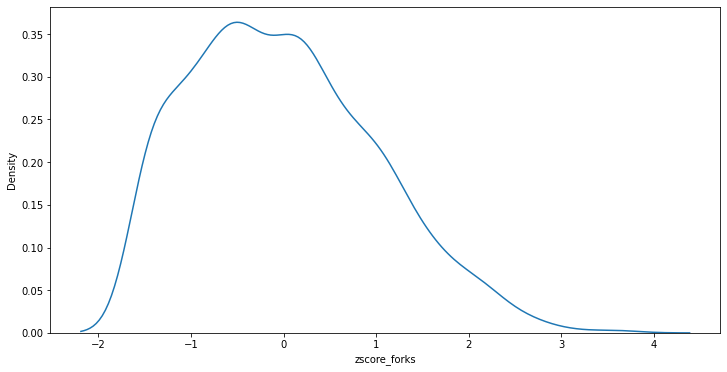

In [67]:
plt.rcParams['figure.figsize'] = [12, 6]
sns.kdeplot(df['zscore_forks'])

<Axes: xlabel='forks', ylabel='vector_forks'>

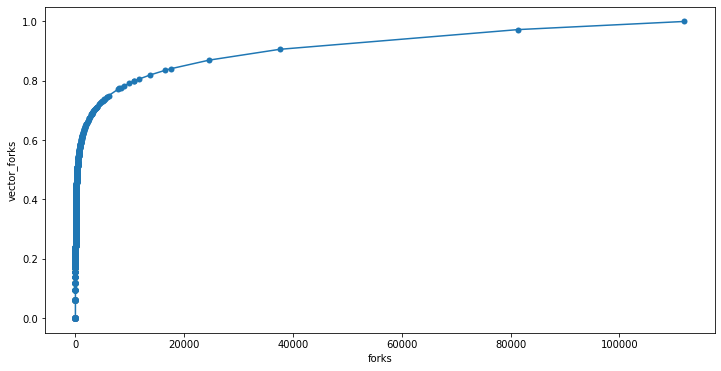

In [68]:
sns.scatterplot(df, x='forks', y='vector_forks', lw=0)
sns.lineplot(df, x='forks', y='vector_forks')

# Analyze

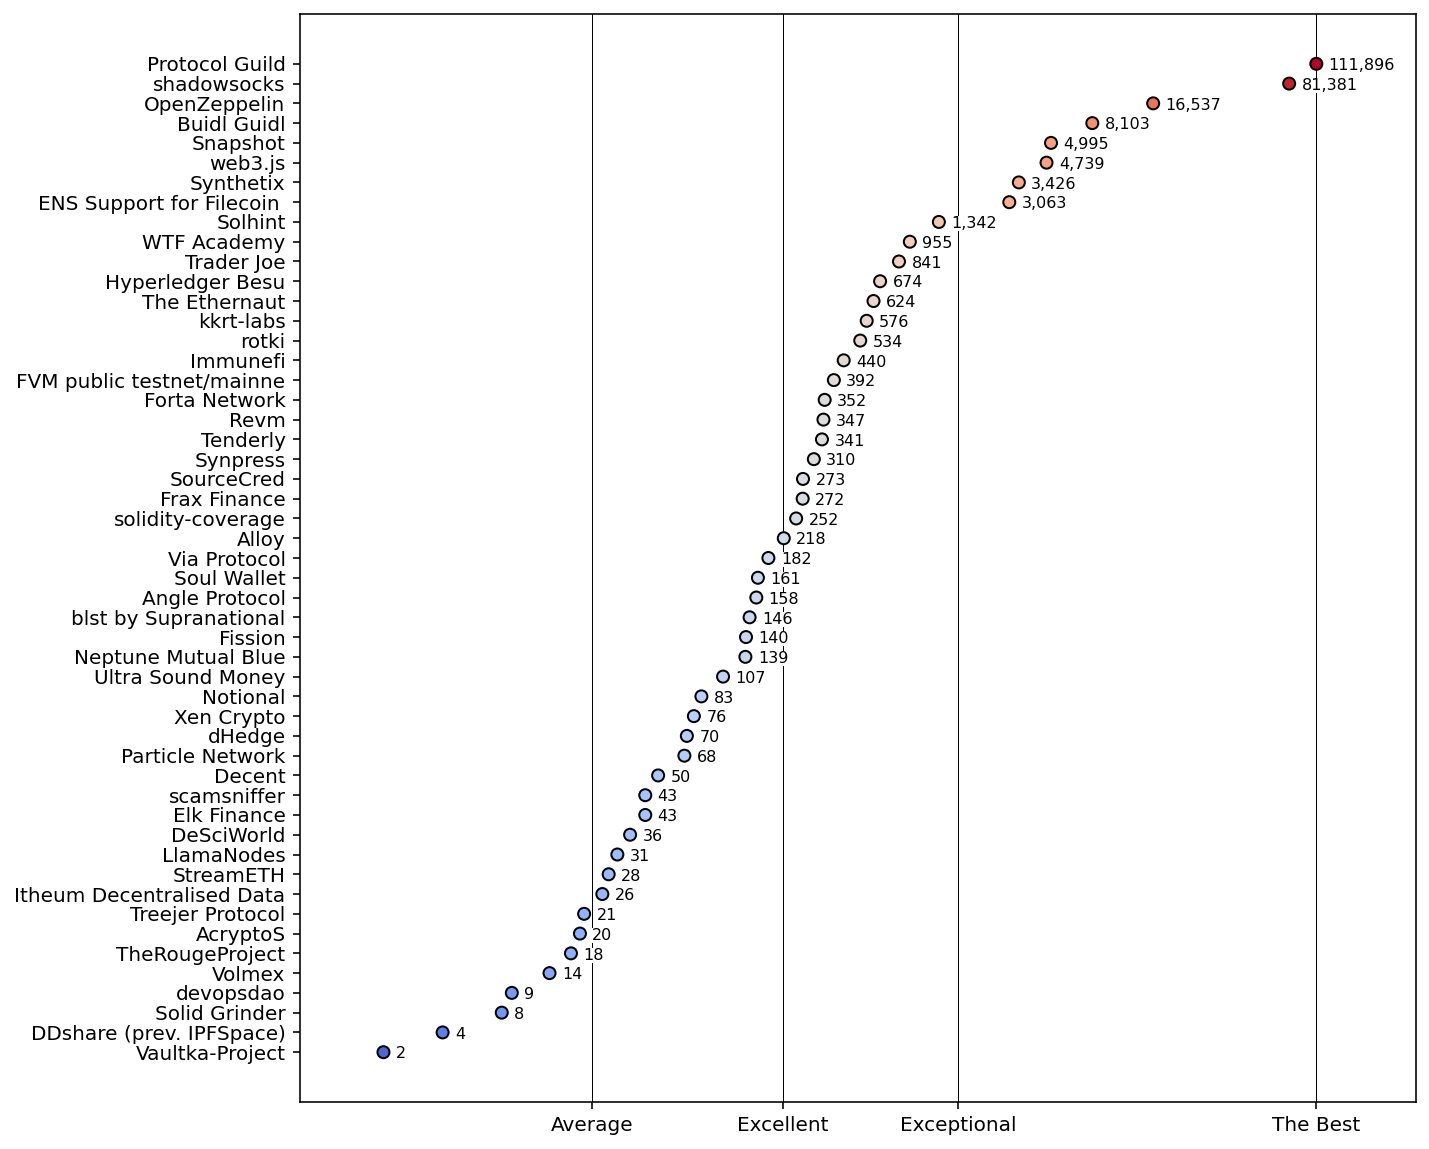

In [186]:
fig, ax = plt.subplots(figsize=(10,10), dpi=144)

# take a sample of 50 projects (including the top 2)
dff = (
    pd.concat([
        df.iloc[:-2,:].sample(48, weights='vector_forks'), 
        df.iloc[-2:,:]
    ], axis=0)
    .sort_values(by='vector_forks')
)

# create a scatter plot showing relative performance
ax.scatter(
    x=dff['vector_forks'], 
    y=[name[:25] for name in dff.index],
    c=dff['zscore_forks'],
    vmin=df['zscore_forks'].min(),
    vmax=df['zscore_forks'].max(),
    cmap='coolwarm', 
    lw=1, 
    edgecolor='black',
    zorder=2
)

# add annotations that show the actual impact metric values
for y,(_,row) in enumerate(dff.iterrows()):
    ax.text(
        s=f"{row['forks']:,.0f}",
        x=row['vector_forks']+.0125,
        y=y-.0875,
        va='center',
        fontsize=8,
        zorder=2,
        bbox=dict(facecolor='white', lw=0, pad=0.01)
    )
    
# provide gridlines for different performance levels    
ax.set_xlim(-0.025,1.1)
ax.set_xticks([
    df['vector_forks'].median(),
    df['vector_forks'].quantile(.8),
    df['vector_forks'].quantile(.95),
    1
], labels=['Average', 'Excellent', 'Exceptional', 'The Best'])
ax.grid(which='major', axis='x', color='black', lw=.5)

# Export

In [11]:
df.to_csv('forks_impact_vector.csv', index=False)